# ResNet Transfer Learning

Loading the pre-trained comvolutional models, removing the last layer and train with small data set.

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Reshape, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
%matplotlib inline
import glob

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from Transfer_learning_utils import convert_to_one_hot, loading_dataset, evaluate_model

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications import ResNet50
ResNetModel = ResNet50()
ResNetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Residuel Network is a moderate-sizied convolutional neural network. It has 50 layers and 25M parameters. This is less than 20% the size of VGG16/VGG19

## load training and testing data

In [3]:
selected_classes = ['garfield','barrel','camera','cannon','crab','crayfish','crocdile','llama','lobster','lotus','sunflower']
folderpath = './../Dataset/Caltech101_Dataset/101_ObjectCategories/'

In [4]:
X_train, Y_train, X_test, Y_test = loading_dataset(folderpath = folderpath, classes = selected_classes)

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train, len(selected_classes)).T
Y_test = convert_to_one_hot(Y_test, len(selected_classes)).T

In [5]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 470
number of test examples = 117
X_train shape: (470, 224, 224, 3)
Y_train shape: (470, 11)
X_test shape: (117, 224, 224, 3)
Y_test shape: (117, 11)


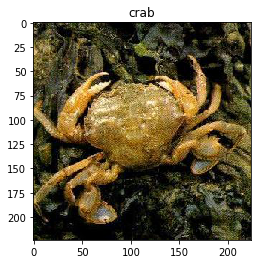

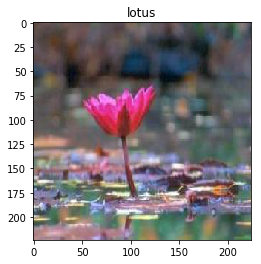

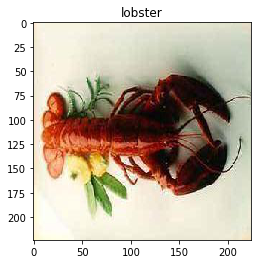

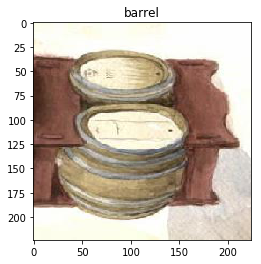

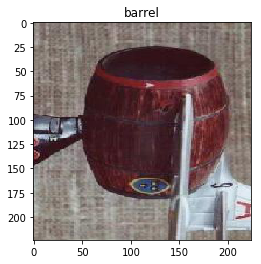

In [6]:
for i in range(5):
    plt.figure()
    plt.imshow(X_train[i]/255.)
    plt.title(selected_classes[np.argmax(Y_train[i])])

## Add new fianl dense layer, set ResNet layers non-trainable

In [7]:
for layer in ResNetModel.layers:
    layer.trainable = False

### Note for Res Net
The last 2 layers of ResNet are flatten and dense. We need to 
1. Remove the last dense
3. Attach a new reshape layer for classfication on new dataset with softmax activation 

In [8]:
new_dense = Dense(len(selected_classes), activation='softmax', name='new_final_layer', kernel_initializer = glorot_uniform(seed=0))(ResNetModel.layers[-2].output)

In [9]:
myResNet = Model(input = ResNetModel.input, output = new_dense)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ne...)`
  """Entry point for launching an IPython kernel.


In [10]:
myResNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [11]:
myResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
featureModel = Model(input = myResNet.input, output = myResNet.layers[-2].output)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  """Entry point for launching an IPython kernel.


In [14]:
nTrain = X_train.shape[0]
nTest = X_test.shape[0]

#nFeature = int(featureModel.output.shape[1])
nFeature = 2048

X_train_feature = np.zeros((nTrain, nFeature))
X_test_feature  = np.zeros((nTest, nFeature))

In [15]:
batch_size = 10
for i in range(0,nTrain,batch_size):
    iEnd = min([nTrain, i+batch_size])
    print('computing features for training data %d - %d' % (i, iEnd-1))
    X_train_feature[i:iEnd] = featureModel.predict(X_train[i:iEnd])    

computing features for training data 0 - 9
computing features for training data 10 - 19
computing features for training data 20 - 29
computing features for training data 30 - 39
computing features for training data 40 - 49
computing features for training data 50 - 59
computing features for training data 60 - 69
computing features for training data 70 - 79
computing features for training data 80 - 89
computing features for training data 90 - 99
computing features for training data 100 - 109
computing features for training data 110 - 119
computing features for training data 120 - 129
computing features for training data 130 - 139
computing features for training data 140 - 149
computing features for training data 150 - 159
computing features for training data 160 - 169
computing features for training data 170 - 179
computing features for training data 180 - 189
computing features for training data 190 - 199
computing features for training data 200 - 209
computing features for training dat

In [16]:
for i in range(0,nTest,batch_size):
    iEnd = min([nTest, i+batch_size])
    print('computing features for test data %d - %d' % (i, iEnd-1))
    X_test_feature[i:iEnd] = featureModel.predict(X_test[i:iEnd])   

computing features for test data 0 - 9
computing features for test data 10 - 19
computing features for test data 20 - 29
computing features for test data 30 - 39
computing features for test data 40 - 49
computing features for test data 50 - 59
computing features for test data 60 - 69
computing features for test data 70 - 79
computing features for test data 80 - 89
computing features for test data 90 - 99
computing features for test data 100 - 109
computing features for test data 110 - 116


In [17]:
pca = decomposition.PCA(n_components = 2)

In [18]:
x_std = StandardScaler().fit_transform(X_train_feature)
x_feature_pca = pca.fit_transform(x_std)

In [19]:
Y_train_label = np.argmax(Y_train,axis=1)

Text(0.5,1,'feature space')

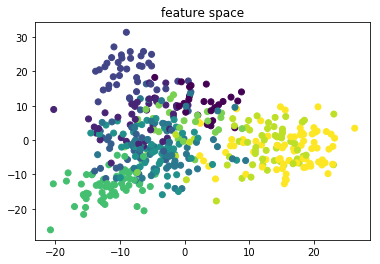

In [20]:
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=Y_train_label)
plt.title('feature space')

### Note:
Before we do anything, the first (n-1) layers of ResNet is already able to distinguage different classes. Here we compute the feature vectors of each training and testing data set, and plot the feature vectors (the first two dimensions in the pca space) colored by their labels. Note that the clusters are decent separated already. The separation is better than MobileNet, and slightly worse than VGG16

In [26]:
final_layer_input = Input(shape=(nFeature,))
final_layer_dense = Dense(len(selected_classes), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(final_layer_input)
myResNet_patch = Model(inputs = final_layer_input, outputs = final_layer_dense)
myResNet_patch.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [27]:
myResNet_patch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                22539     
Total params: 22,539
Trainable params: 22,539
Non-trainable params: 0
_________________________________________________________________


In [28]:
evaluate_model(myResNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)

Performance on Training data set (470)
470/470 [==============================] - 0s 937us/step
Loss = 2.5162435440306967
Train Accuracy = 0.10638297885022265
Performance on Testing data set (117)
117/117 [==============================] - 0s 72us/step
Loss = 2.7004383832980423
Test Accuracy = 0.05128205128205128


(2.5162435440306967,
 0.10638297885022265,
 2.7004383832980423,
 0.05128205128205128)

In [29]:
loss_train = []
loss_test = []
acc_train = []
acc_test = []

In [31]:
for i in range(100):
    print('Training on %d-th round' % i)
    myResNet_patch.fit(X_train_feature, Y_train, epochs = 2, batch_size = 32)
    ltr, atr, lte, ate = evaluate_model(myResNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)
    loss_train.append(ltr)
    acc_train.append(atr)
    loss_test.append(lte)
    acc_test.append(ate)


Training on 0-th round
Epoch 1/2
470/470 [==============================] - 0s 1ms/step - loss: 1.5827 - acc: 0.4766
Epoch 2/2
470/470 [==============================] - 0s 76us/step - loss: 0.5280 - acc: 0.8723
Performance on Training data set (470)
470/470 [==============================] - 0s 42us/step
Loss = 0.3343327476623211
Train Accuracy = 0.9191489354093024
Performance on Testing data set (117)
117/117 [==============================] - 0s 65us/step
Loss = 0.6827988211925213
Test Accuracy = 0.7692307722874177
Training on 1-th round
Epoch 1/2
470/470 [==============================] - 0s 79us/step - loss: 0.2849 - acc: 0.9234
Epoch 2/2
470/470 [==============================] - 0s 75us/step - loss: 0.1879 - acc: 0.9702
Performance on Training data set (470)
470/470 [==============================] - 0s 46us/step
Loss = 0.1420397938566005
Train Accuracy = 0.985106382217813
Performance on Testing data set (117)
117/117 [==============================] - 0s 61us/step
Loss = 0.5590

470/470 [==============================] - 0s 74us/step - loss: 0.0080 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 76us/step - loss: 0.0076 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 42us/step
Loss = 0.007328131949489421
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 51us/step
Loss = 0.4660777579515408
Test Accuracy = 0.8547008567386203
Training on 17-th round
Epoch 1/2
470/470 [==============================] - 0s 75us/step - loss: 0.0073 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 80us/step - loss: 0.0070 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 42us/step
Loss = 0.0067156947198066304
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 63us/step
Loss = 0.468739037330334
Test Accuracy = 0.8461538487010531
Training

470/470 [==============================] - 0s 70us/step - loss: 0.0028 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 69us/step - loss: 0.0027 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 46us/step
Loss = 0.002635438895804134
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 55us/step
Loss = 0.4839394545962668
Test Accuracy = 0.8632478652856289
Training on 33-th round
Epoch 1/2
470/470 [==============================] - 0s 73us/step - loss: 0.0026 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 76us/step - loss: 0.0026 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 48us/step
Loss = 0.0025119042697739095
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 78us/step
Loss = 0.48666657112602496
Test Accuracy = 0.8632478652856289
Traini

470/470 [==============================] - 0s 73us/step - loss: 0.0014 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 71us/step - loss: 0.0014 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 48us/step
Loss = 0.001366325325649628
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 74us/step
Loss = 0.5009071582402939
Test Accuracy = 0.8717948738326374
Training on 49-th round
Epoch 1/2
470/470 [==============================] - 0s 77us/step - loss: 0.0014 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 76us/step - loss: 0.0013 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 41us/step
Loss = 0.0013199322133701531
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 63us/step
Loss = 0.5019366264852703
Test Accuracy = 0.8632478652856289
Trainin

470/470 [==============================] - 0s 85us/step - loss: 8.5015e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 73us/step - loss: 8.3888e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 42us/step
Loss = 0.0008283392858116868
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 65us/step
Loss = 0.512361486752828
Test Accuracy = 0.8717948738326374
Training on 65-th round
Epoch 1/2
470/470 [==============================] - 0s 67us/step - loss: 8.2736e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 69us/step - loss: 8.1605e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 46us/step
Loss = 0.0008057603136973178
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 73us/step
Loss = 0.5123473118003617
Test Accuracy = 0.87179487

117/117 [==============================] - 0s 67us/step
Loss = 0.5248310942935128
Test Accuracy = 0.8717948738326374
Training on 80-th round
Epoch 1/2
470/470 [==============================] - 0s 71us/step - loss: 5.5860e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 69us/step - loss: 5.5211e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 45us/step
Loss = 0.0005455639324785072
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 57us/step
Loss = 0.5273320835370284
Test Accuracy = 0.8717948738326374
Training on 81-th round
Epoch 1/2
470/470 [==============================] - 0s 76us/step - loss: 5.4531e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 73us/step - loss: 5.3974e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 43us/step
Loss = 0.0005328154481174623
Train Accuracy 

470/470 [==============================] - 0s 38us/step
Loss = 0.00038668184635288854
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 63us/step
Loss = 0.5370180527878623
Test Accuracy = 0.8717948738326374
Training on 96-th round
Epoch 1/2
470/470 [==============================] - 0s 80us/step - loss: 3.8635e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 100us/step - loss: 3.8192e-04 - acc: 1.0000
Performance on Training data set (470)
470/470 [==============================] - 0s 53us/step
Loss = 0.00037840690458827513
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 62us/step
Loss = 0.5360380991911277
Test Accuracy = 0.8717948738326374
Training on 97-th round
Epoch 1/2
470/470 [==============================] - 0s 75us/step - loss: 3.7792e-04 - acc: 1.0000
Epoch 2/2
470/470 [==============================] - 0s 70us/step - loss: 3.7385e-04 - acc:

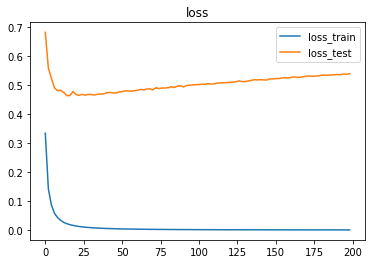

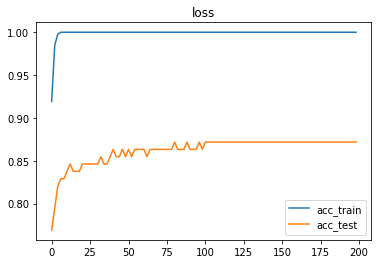

In [32]:
plt.figure()
plt.plot(range(0,200,2), loss_train, label = 'loss_train')
plt.plot(range(0,200,2), loss_test, label = 'loss_test')
plt.title('loss')
plt.legend()

plt.figure()
plt.plot(range(0,200,2), acc_train, label = 'acc_train')
plt.plot(range(0,200,2), acc_test, label = 'acc_test')
plt.title('loss')
plt.legend()

In [25]:
#the following code will take long time because we are computing the feature vector for each training data repeatedly

#myVGGNet.fit(X_train, Y_train, epochs = 2, batch_size = 32)

In [26]:
#evaluate_model(myVGGNet, X_train, Y_train, X_test, Y_test, maxItem = 20)

In [27]:
#prediction_result = myVGGNet.predict(X_test[0:10])
#predicted_labels = np.argmax(prediction_result,axis=1)

In [35]:
myResNet_patch.fit(X_train_feature, Y_train, epochs = 250, batch_size = 32)

Epoch 1/250
470/470 [==============================] - 0s 93us/step - loss: 3.5455e-04 - acc: 1.0000
Epoch 2/250
470/470 [==============================] - 0s 78us/step - loss: 3.5064e-04 - acc: 1.0000
Epoch 3/250
470/470 [==============================] - 0s 78us/step - loss: 3.4697e-04 - acc: 1.0000
Epoch 4/250
470/470 [==============================] - 0s 75us/step - loss: 3.4351e-04 - acc: 1.0000
Epoch 5/250
470/470 [==============================] - 0s 79us/step - loss: 3.3943e-04 - acc: 1.0000
Epoch 6/250
470/470 [==============================] - 0s 72us/step - loss: 3.3619e-04 - acc: 1.0000
Epoch 7/250
470/470 [==============================] - 0s 81us/step - loss: 3.3281e-04 - acc: 1.0000
Epoch 8/250
470/470 [==============================] - 0s 76us/step - loss: 3.2875e-04 - acc: 1.0000
Epoch 9/250
470/470 [==============================] - 0s 80us/step - loss: 3.2602e-04 - acc: 1.0000
Epoch 10/250
470/470 [==============================] - 0s 69us/step - loss: 3.2254e-04 - a

470/470 [==============================] - 0s 101us/step - loss: 1.6273e-04 - acc: 1.0000
Epoch 82/250
470/470 [==============================] - 0s 80us/step - loss: 1.6141e-04 - acc: 1.0000
Epoch 83/250
470/470 [==============================] - 0s 86us/step - loss: 1.5998e-04 - acc: 1.0000
Epoch 84/250
470/470 [==============================] - 0s 80us/step - loss: 1.5858e-04 - acc: 1.0000
Epoch 85/250
470/470 [==============================] - 0s 78us/step - loss: 1.5725e-04 - acc: 1.0000
Epoch 86/250
470/470 [==============================] - 0s 87us/step - loss: 1.5589e-04 - acc: 1.0000
Epoch 87/250
470/470 [==============================] - 0s 86us/step - loss: 1.5430e-04 - acc: 1.0000
Epoch 88/250
470/470 [==============================] - 0s 95us/step - loss: 1.5319e-04 - acc: 1.0000
Epoch 89/250
470/470 [==============================] - 0s 81us/step - loss: 1.5170e-04 - acc: 1.0000
Epoch 90/250
470/470 [==============================] - 0s 68us/step - loss: 1.5037e-04 - acc:

470/470 [==============================] - 0s 71us/step - loss: 8.2598e-05 - acc: 1.0000
Epoch 161/250
470/470 [==============================] - 0s 78us/step - loss: 8.1839e-05 - acc: 1.0000
Epoch 162/250
470/470 [==============================] - 0s 65us/step - loss: 8.1292e-05 - acc: 1.0000
Epoch 163/250
470/470 [==============================] - 0s 68us/step - loss: 8.0533e-05 - acc: 1.0000
Epoch 164/250
470/470 [==============================] - 0s 75us/step - loss: 7.9914e-05 - acc: 1.0000
Epoch 165/250
470/470 [==============================] - 0s 70us/step - loss: 7.9196e-05 - acc: 1.0000
Epoch 166/250
470/470 [==============================] - 0s 79us/step - loss: 7.8535e-05 - acc: 1.0000
Epoch 167/250
470/470 [==============================] - 0s 71us/step - loss: 7.7896e-05 - acc: 1.0000
Epoch 168/250
470/470 [==============================] - 0s 70us/step - loss: 7.7273e-05 - acc: 1.0000
Epoch 169/250
470/470 [==============================] - 0s 75us/step - loss: 7.6616e-0

470/470 [==============================] - 0s 67us/step - loss: 4.3681e-05 - acc: 1.0000
Epoch 240/250
470/470 [==============================] - 0s 71us/step - loss: 4.3294e-05 - acc: 1.0000
Epoch 241/250
470/470 [==============================] - 0s 70us/step - loss: 4.2974e-05 - acc: 1.0000
Epoch 242/250
470/470 [==============================] - 0s 70us/step - loss: 4.2630e-05 - acc: 1.0000
Epoch 243/250
470/470 [==============================] - 0s 74us/step - loss: 4.2317e-05 - acc: 1.0000
Epoch 244/250
470/470 [==============================] - 0s 63us/step - loss: 4.1997e-05 - acc: 1.0000
Epoch 245/250
470/470 [==============================] - 0s 74us/step - loss: 4.1661e-05 - acc: 1.0000
Epoch 246/250
470/470 [==============================] - 0s 73us/step - loss: 4.1327e-05 - acc: 1.0000
Epoch 247/250
470/470 [==============================] - 0s 72us/step - loss: 4.0976e-05 - acc: 1.0000
Epoch 248/250
470/470 [==============================] - 0s 73us/step - loss: 4.0665e-0

In [36]:
evaluate_model(myResNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)

Performance on Training data set (470)
470/470 [==============================] - 0s 44us/step
Loss = 3.9746159234980835e-05
Train Accuracy = 1.0
Performance on Testing data set (117)
117/117 [==============================] - 0s 58us/step
Loss = 0.5906081423800216
Test Accuracy = 0.8632478652856289


(3.9746159234980835e-05, 1.0, 0.5906081423800216, 0.8632478652856289)

In [37]:
prediction_result = myResNet_patch.predict(X_test_feature)
predicted_labels = np.argmax(prediction_result,axis=1)
prediction_conf = np.max(prediction_result, axis = 1)

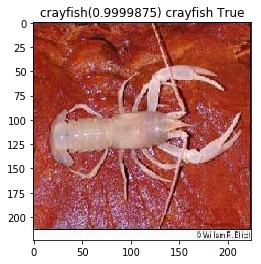

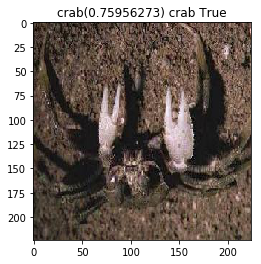

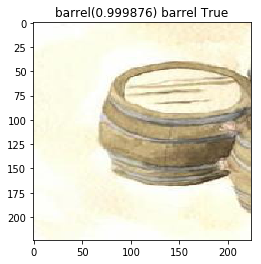

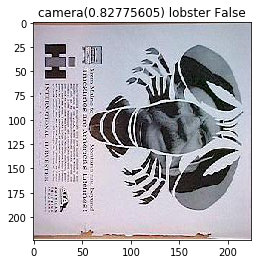

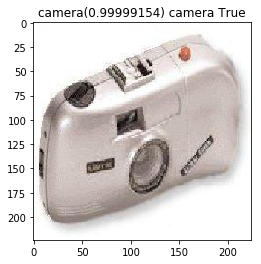

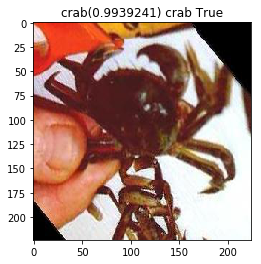

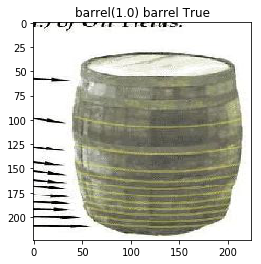

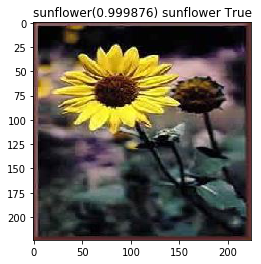

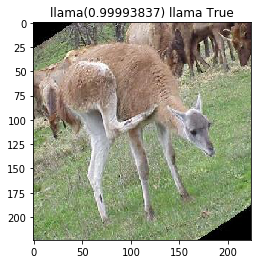

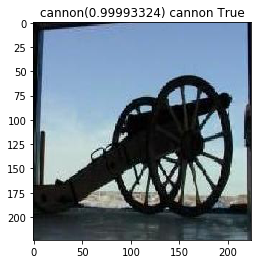

In [38]:
for i in range(10):
    actu = np.argmax(Y_test[i])
    plt.figure()
    plt.imshow(X_test[i]/255.)
    plt.title(selected_classes[predicted_labels[i]] + '(' + str(prediction_conf[i])+') ' + selected_classes[actu] + ' ' + str(predicted_labels[i]==actu))

## Note
The performance of transfer learning with ResNet achieved 100% accuracy with training dataset and 95.5% accuracy with test dataset. This is exactly the same with MobileNet. Training takes about the same time but computing feature vectors takes slightly longer time. The model is also 600% the size of MobileNet, and is 19% the size of VGG16.

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))